In [3]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import datasets
from tqdm.notebook import tqdm

torch.manual_seed(32)

In [4]:
f = True
X = []
y = []
with open(
    "../../data/diabetes1.csv",
    newline="",
) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if f:
            print(row)
            f = False
        X.append(np.array([float(row["Age"]), float(row["Glucose"])]))
        y.append(np.intc(1 if row["Outcome"].strip().upper() == "1" else 0))
X = np.array(X)
y = np.array(y)

x_data = torch.Tensor(X)
y_data = torch.Tensor(y.reshape(len(X), 1))

{'Pregnancies': '6', 'Glucose': '148', 'BloodPressure': '72', 'SkinThickness': '35', 'Insulin': '0', 'BMI': '33.6', 'DiabetesPedigreeFunction': '0.627', 'Age': '50', 'Outcome': '1'}


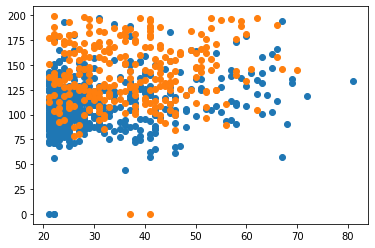

In [5]:
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])

In [71]:
class Model(nn.Module):
    def __init__(self, input_size, layers, output_size):
        super().__init__()
        self.layers = []
        first = True
        for node_size in layers:
            if first:
                item = nn.Linear(input_size, layers[0])
                setattr(self, str(hash(item)), item)
                self.layers.append(item)
                previous_node_size = layers[0]
                first = False
                continue
            else:
                item = nn.Linear(previous_node_size, node_size)
                setattr(self, str(hash(item)), item)
                self.layers.append(item)
            previous_node_size = node_size
        item = nn.Linear(previous_node_size, output_size)
        setattr(self, str(hash(item)), item)
        self.layers.append(item)

    def forward(self, x):
        for layer in self.layers:
            x = torch.sigmoid(layer(x))
        return x

    def predict(self, x):
        pred = self.forward(x)
        if pred >= 0.5:
            return 1
        else:
            return 0

In [96]:
model = Model(2, [6, 6, 6], 1)
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.2639,  0.1255],
        [-0.4709, -0.6637],
        [-0.3782, -0.2814],
        [-0.5911, -0.1895],
        [-0.2782,  0.3041],
        [ 0.2234, -0.3589]], requires_grad=True), Parameter containing:
tensor([ 0.6360,  0.3059, -0.6850, -0.3637,  0.1755,  0.1452],
       requires_grad=True), Parameter containing:
tensor([[ 5.9926e-02, -9.6093e-02, -2.9567e-01,  3.3602e-01, -3.4905e-01,
          6.6903e-02],
        [ 1.4635e-01,  1.4514e-01,  1.0347e-01, -2.1377e-01,  7.9751e-03,
         -1.8370e-01],
        [ 3.3567e-01, -1.8665e-01,  1.1286e-01, -6.7231e-03,  2.9382e-01,
          7.1321e-02],
        [ 2.8230e-01, -6.4931e-02,  2.2026e-01,  2.1449e-01,  1.3417e-01,
          2.7747e-01],
        [-9.1956e-02,  3.8194e-01,  2.4510e-01,  2.2306e-01, -2.8218e-01,
          3.0952e-05],
        [ 3.3462e-01,  1.4852e-01, -1.9415e-01,  4.0235e-01,  5.4096e-02,
         -1.5747e-01]], requires_grad=True), Parameter containing:
tensor([ 0.1975,  0.3852, 

In [97]:
model.layers

[Linear(in_features=2, out_features=6, bias=True),
 Linear(in_features=6, out_features=6, bias=True),
 Linear(in_features=6, out_features=6, bias=True),
 Linear(in_features=6, out_features=1, bias=True)]

In [98]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2639,  0.1255],
         [-0.4709, -0.6637],
         [-0.3782, -0.2814],
         [-0.5911, -0.1895],
         [-0.2782,  0.3041],
         [ 0.2234, -0.3589]], requires_grad=True),
 Parameter containing:
 tensor([ 0.6360,  0.3059, -0.6850, -0.3637,  0.1755,  0.1452],
        requires_grad=True),
 Parameter containing:
 tensor([[ 5.9926e-02, -9.6093e-02, -2.9567e-01,  3.3602e-01, -3.4905e-01,
           6.6903e-02],
         [ 1.4635e-01,  1.4514e-01,  1.0347e-01, -2.1377e-01,  7.9751e-03,
          -1.8370e-01],
         [ 3.3567e-01, -1.8665e-01,  1.1286e-01, -6.7231e-03,  2.9382e-01,
           7.1321e-02],
         [ 2.8230e-01, -6.4931e-02,  2.2026e-01,  2.1449e-01,  1.3417e-01,
           2.7747e-01],
         [-9.1956e-02,  3.8194e-01,  2.4510e-01,  2.2306e-01, -2.8218e-01,
           3.0952e-05],
         [ 3.3462e-01,  1.4852e-01, -1.9415e-01,  4.0235e-01,  5.4096e-02,
          -1.5747e-01]], requires_grad=True),
 Parameter containing:
 te

In [99]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [100]:
epochs = 15000
losses = []

progress_bar = tqdm(range(epochs))
for i in progress_bar:
    y_pred = model.forward(x_data)
    loss = criterion(y_pred, y_data)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.set_description(f"epoch: {i} loss: {loss.item()}")

  0%|          | 0/15000 [00:00<?, ?it/s]

Loss over time


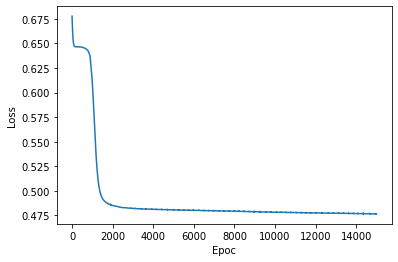

In [101]:
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoc")
print("Loss over time")

In [102]:
def plot_decision_boundry(X, y):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0] + 0.25))
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1] + 0.25))
    xx, yy = np.meshgrid(x_span, y_span)
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    pred_func = model.forward(grid)
    z = pred_func.view(xx.shape).detach().numpy()
    plt.contourf(xx, yy, z)
    plt.scatter(X[y == 0, 0], X[y == 0, 1])
    plt.scatter(X[y == 1, 0], X[y == 1, 1])

Trained Network


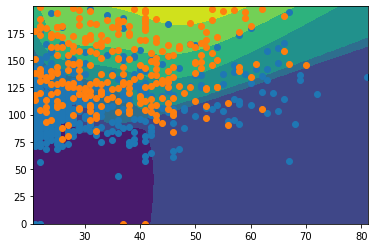

In [103]:
print("Trained Network")
plot_decision_boundry(X, y)

First Prediction, item in center of graph, group 1
0


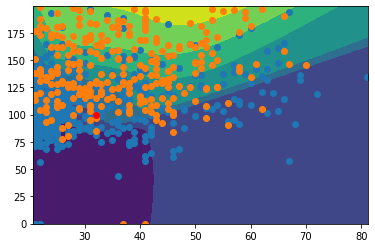

In [104]:
age = 32
bgl = 100
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("First Prediction, item in center of graph, group 1")
print(pred)
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)

First Prediction, item in center of graph, group 1
1


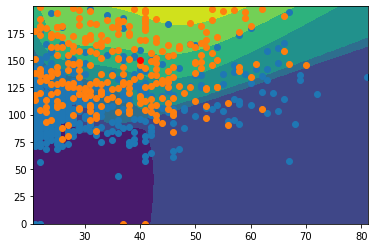

In [105]:
age = 40
bgl = 150
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("First Prediction, item in center of graph, group 1")
print(pred)
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)